In [113]:
# Load packages
# System packages
import os
import datetime
import warnings
warnings.simplefilter("ignore", UserWarning)

# Data related
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 50)

# Visualization 
import seaborn as sns, matplotlib.pyplot as plt


# Text analysis helper libraries
from gensim.summarization import summarize, keywords
from gensim.models import KeyedVectors


# Text analysis helper libraries for word frequency
import nltk
# Download stop words 
#nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation


# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter


# Dimensionaly reduction libraries
from sklearn.decomposition import PCA

# Clustering library
from sklearn.cluster import KMeans


[nltk_data] Downloading package wordnet to /Users/j/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import pip 
for i in pip.get_installed_distributions(local_only=True):
    print(i)

## 0 Functions

In [19]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [55]:
# Directory to save plots
createFolder('../reports/figures')
plot='../reports/figures'

### Data munging functions

In [ ]:
def dm(data):
    '''
    Summarize data column features in a new data frame
    '''
    unique_data = pd.DataFrame(columns =('colname','dtype','Null_sum','unique_number','unique_values'))
    for col in data:
        if data[col].nunique() <25:
            unique_data = unique_data.append({'colname': col, \
                                              'dtype': data[col].dtype,\
                                              'Null_sum':data[col].isnull().sum(),\
                                              'unique_number': data[col].nunique(),\
                                              'unique_values':data[col].unique()}, \
                                     ignore_index=True)
        else:
            unique_data = unique_data.append({'colname': col, \
                                              'dtype': data[col].dtype,\
                                              'Null_sum':data[col].isnull().sum(),\
                                              'unique_number': data[col].nunique(),\
                                              'unique_values':'>25'}, \
                                     ignore_index=True)
    return unique_data.sort_values(by=['unique_number','dtype'])

## Plot functions

In [ ]:
# Bar Plot: Count by colname 
def plot_col_count(df,colname,save_plot_dir):
    df=df.drop_duplicates()
    number = df[colname].value_counts().values
    number = [str(x) for x in number.tolist()]
    number = ['n: ' + i for i in number]
    ax = sns.countplot(x=colname,  data=df)
    
    pos = range(len(number))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], + 0.1, number[tick], horizontalalignment='center', size='small', color='w', weight='semibold')    
    
    fig = ax.get_figure()
    
    #save plot
    name= str(colname)+'count'
    figname = '{}{:%Y%m%dT%H%M}.png'.format(os.path.join(save_plot_dir,name), datetime.datetime.now())
    fig.savefig(figname, figdpi = 300)

In [77]:
# Frequency plot of a col
def frequency_plot(df,colname,save_plot_dir):
    plt.figure()
    ax = train[colname].value_counts().plot(kind='area')
    ax.get_xaxis().set_ticks([])
    ax.set_title('Train Data: ' + str(colname) +' Frequency Plot')
    ax.set_xlabel(colname)
    ax.set_ylabel('Frequency')
    plt.tight_layout()    
    #save plot
    name= str(colname)+'_frequency'
    plotname = '{}{:%Y%m%dT%H%M}.png'.format(os.path.join(save_plot_dir,name), datetime.datetime.now())
    plt.savefig(plotname, figdpi = 300)
    

In [ ]:
def resize_image(np_img, new_size):
    old_size = np_img.shape
    ratio = min(new_size[0]/old_size[0], new_size[1]/old_size[1])

    return imresize(np_img, (round(old_size[0]*ratio), round(old_size[1]*ratio)))

### Word2Vec

In [ ]:
def get_average_vector(text):
    tokens = [w.lower() for w in word_tokenize(text) if w.lower() not in stop_words]
    return np.mean(np.array([model.wv[w] for w in tokens if w in model]), axis=0)


## 1 EDA: 

### 1. Inspect data

In [22]:
print(os.listdir('../data/raw'))
# Input data files are available in the "../data/raw/" directory.

['training_text', 'training_variants', '.DS_Store', 'not_used', 'test_text', '.gitkeep', 'test_variants']


In [25]:
# Training Data
train_v = pd.read_csv('../data/raw/training_variants')
print('1) training_variants:')
print('')
print(train_v.head(2))

# Training text
train_t = pd.read_csv('../data/raw/training_text', sep='\|\|', header=None, skiprows=1, \
                      names=["ID","Text"],engine='python')
print('2) training_text:') 
print(train_t.head(2))
print('')

1) training_variants:

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2) training_text:
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...



In [24]:
# Test Data for prediction
test_v = pd.read_csv('../data/raw/test_variants')
print('1) test_variants:') 
print(test_v.head(2))
print(' ')
# Test Text
test_t = pd.read_csv('../data/raw/test_text', sep='\|\|', header=None, skiprows=1, \
                      names=["ID","Text"],engine='python')
print('2) test_text:') 
print(test_t.head(2))
print(' ')

1) test_variants:
   ID   Gene Variation
0   0  ACSL4     R570S
1   1  NAGLU     P521L
 
2) test_text:
   ID                                               Text
0   0  2. This mutation resulted in a myeloproliferat...
1   1   Abstract The Large Tumor Suppressor 1 (LATS1)...
 


### 1.2 Prepare a new dataframe which combines all information 

In [26]:
# Merge train variants and text by unique ID
print('1)Merge train text variants and text')
print(train_v.ID.unique())
print(train_t.ID.unique())
train = pd.merge(train_v,train_t,on='ID',how='left')
print(train.head(2))
print('')


# Merge test variants and text by unique ID
print('2) Merge test text variants and text')
print(test_v.ID.unique())
print(test_t.ID.unique())
test = pd.merge(test_v,test_t,on='ID',how='left')
print(test.head(2))

1)Merge train text variants and text
[   0    1    2 ... 3318 3319 3320]
[   0    1    2 ... 3318 3319 3320]
   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  

2) Merge test text variants and text
[   0    1    2 ... 5665 5666 5667]
[   0    1    2 ... 5665 5666 5667]
   ID   Gene Variation                                               Text
0   0  ACSL4     R570S  2. This mutation resulted in a myeloproliferat...
1   1  NAGLU     P521L   Abstract The Large Tumor Suppressor 1 (LATS1)...


In [28]:
# Save data
train.to_csv('../data/processed/train_variants_text.csv',index=False)
test.to_csv('../data/processed/test_variants_text.csv',index=False)

### 1.3 Data Munging

###  What is the prediction target?
Class
### What is the distribution of the target?

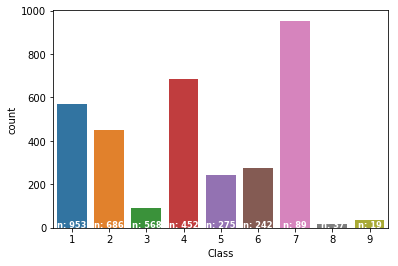

In [54]:
# Train dataset. count by Class
plot_col_count(train,'Class',plot)

### What should we inspect on the data?
1) What are the column types?  
2) Are there null values in the columns?  
3) What's the unique number of column value?  
4) What are the unique values in the columns?  

In [44]:
dm(train)

,colname,dtype,Null_sum,unique_number,unique_values
3,Class,int64,0,9,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,Gene,object,0,264,>25
4,Text,object,5,1920,>25
2,Variation,object,0,2996,>25
0,ID,int64,0,3321,>25


### What is the distribution of the 'Gene' variable?

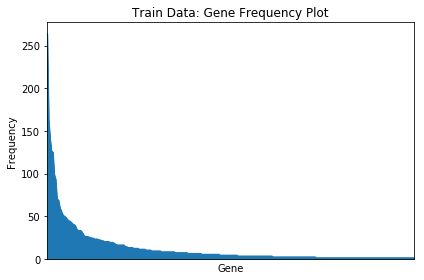

In [78]:
frequency_plot(train,'Gene',plot)

### Remove rows whose without 'Text' information

In [81]:
df = train[train['Text'] != 'null']

## What are the important words in the 'Text' column?

In [89]:
# TextRank algorithm from gensim
t_id = 0
text = df.loc[t_id, 'Text']


In [99]:
word_scores = keywords(text, words=5, scores=True, \
                       split=True, lemmatize=True)

word_scores
#summary = summarize(text, word_count=100)
#print('ID [{}]\nKeywords: [{}]\nSummary: [{}]'.format(t_id, word_scores, summary))


[('cdk', 0.39947685026634644),
 ('cell', 0.2278256568053193),
 ('ets', 0.21879425363167276),
 ('proteins', 0.21544496846068056),
 ('cyclins', 0.1720055314740566)]

### Remove stop words and lemmatized words for word frequency analysis

In [114]:
wordnet_lemmatizer = WordNetLemmatizer()

custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”"]

stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)

### Build a corpus for each class

In [ ]:
class_corpus = df.groupby('Class').apply(lambda x: x['Text'].str.cat())
class_corpus = class_corpus.apply(lambda x: Counter(
    [wordnet_lemmatizer.lemmatize(w) 
     for w in word_tokenize(x) 
     if w.lower() not in stop_words and not w.isdigit()]
))

#class_corpus.to_csv('../data/processed/class_corpus.txt',sep='\t',index=False)

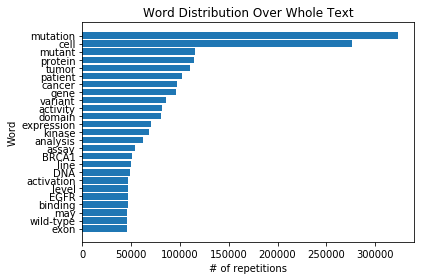

In [202]:
whole_text_freq = class_corpus.sum()

fig, ax = plt.subplots()

label, repetition = zip(*whole_text_freq.most_common(25))

ax.barh(range(len(label)), repetition, align='center')
ax.set_yticks(np.arange(len(label)))
ax.set_yticklabels(label)
ax.invert_yaxis()

ax.set_title('Word Distribution Over Whole Text')
ax.set_xlabel('# of repetitions')
ax.set_ylabel('Word')

plt.tight_layout()
plt.show()

## Generate a word cloud

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


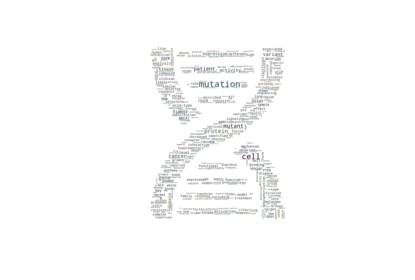

In [213]:
mask_image = np.array(Image.open('../reports/dna_stencil.png').convert('L'))
mask_image = resize_image(mask_image, (4000, 2000))

wc = WordCloud(max_font_size=140,
               min_font_size=8,
               max_words=1000,
               width=mask_image.shape[1], 
               height=mask_image.shape[0],
               prefer_horizontal=.9,
               relative_scaling=.52,
               background_color=None,
               mask=mask_image,
               mode="RGBA").generate_from_frequencies(whole_text_freq)

plt.figure()
plt.axis("off")
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.savefig('../reports/figures/corpus_wordcount.png', dpi=300)

### Word2Vec using Google's pretrained word2vec tokens.

In [215]:
vector_path = r"/Users/j/Dropbox/Learn/kaggle_quora/src/data/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"

model = KeyedVectors.load_word2vec_format (vector_path, binary=True)
model.wv.similar_by_word('mutation')

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


[('mutations', 0.854192316532135),
 ('genetic_mutation', 0.824504554271698),
 ('mutated_gene', 0.7879970073699951),
 ('gene_mutation', 0.7823828458786011),
 ('genetic_mutations', 0.7393666505813599),
 ('gene', 0.7343354225158691),
 ('gene_mutations', 0.7275243401527405),
 ('genetic_variant', 0.7182294130325317),
 ('alleles', 0.7164380550384521),
 ('mutant_gene', 0.7144375443458557)]

In [221]:
model.wv.similar_by_vector(get_average_vector(df.loc[0, 'Text']))

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('cyclic_AMP_cAMP', 0.7952698469161987),
 ('oncogenic_transformation', 0.7863239645957947),
 ('mRNA_transcripts', 0.7860901355743408),
 ('MT1_MMP', 0.7778975963592529),
 ('microRNA_molecule', 0.7758697271347046),
 ('tumorigenicity', 0.7754373550415039),
 ('transgene_expression', 0.7749923467636108),
 ('coexpression', 0.7743014097213745),
 ('transgenic_mice_expressing', 0.7720569968223572),
 ('cyclin_B1', 0.7714494466781616)]

In [ ]:
text_vecs = df.apply(lambda x: (x['Class'], get_average_vector(x['Text'])), axis=1)
classes, vecs = list(zip(*text_vecs.values))

pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(vecs)

fig, ax = plt.subplots()

cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=8)


plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

plt.show()

/Users/j/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
plt.savefig('../reports/figures/pca_class_vector.png', dpi=300)